In [1]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble.gradient_boosting import train_test_split

import os
import time
import datetime

In [2]:
#Importing the Data
digit_data = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

In [3]:
(X_train,X_val) = train_test_split(digit_data, test_size=.1)
y_train = X_train['label']
y_val = X_val['label']
X_train = X_train.drop('label', axis=1) / 255.0
X_val = X_val.drop('label', axis=1) / 255.0
X_test = X_test / 255.0

In [4]:
X_train.shape

(37800, 784)

In [5]:
class_names = [0,1,2,3,4,5,6,7,8,9]

In [6]:
model = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(300,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])
model1 = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(1000,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])
model2 = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(500,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])
model3 = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(300,activation='relu'),
    Dense(100,activation='relu'),
    Dense(300,activation='relu'),
    Dense(100,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])
model4 = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(200,activation='relu'),
    Dense(200,activation='relu'),
    Dense(200,activation='relu'),
    Dense(100,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])

models = [model,model1,model2,model3,model4]

In [7]:
for m in models:
    m.compile(loss='sparse_categorical_crossentropy',
        optimizer='sgd',
        metrics=['accuracy'])

In [8]:
checkpoints = []
times = []
i = 0
for m in models:
    checkpoint_cb = keras.callbacks.ModelCheckpoint(f'my_keras_model{i}.h5', save_best_only=True)
    start_time = datetime.datetime.now()
    m.fit(X_train,y_train,
        epochs=40,
        validation_data=(X_val,y_val), callbacks=[checkpoint_cb])
    end_time = datetime.datetime.now()
    times.append(end_time-start_time)
    i+=1

: 0.9712
Epoch 23/40
1182/1182 [==============================] - 3s 3ms/step - loss: 0.0431 - accuracy: 0.9898 - val_loss: 0.0959 - val_accuracy: 0.9719
Epoch 24/40
1182/1182 [==============================] - 3s 3ms/step - loss: 0.0404 - accuracy: 0.9907 - val_loss: 0.0963 - val_accuracy: 0.9714
Epoch 25/40
1182/1182 [==============================] - 3s 3ms/step - loss: 0.0378 - accuracy: 0.9917 - val_loss: 0.0915 - val_accuracy: 0.9724
Epoch 26/40
1182/1182 [==============================] - 3s 3ms/step - loss: 0.0351 - accuracy: 0.9922 - val_loss: 0.0935 - val_accuracy: 0.9726
Epoch 27/40
1182/1182 [==============================] - 3s 3ms/step - loss: 0.0329 - accuracy: 0.9930 - val_loss: 0.0940 - val_accuracy: 0.9724
Epoch 28/40
1182/1182 [==============================] - 3s 3ms/step - loss: 0.0311 - accuracy: 0.9934 - val_loss: 0.0923 - val_accuracy: 0.9745
Epoch 29/40
1182/1182 [==============================] - 3s 3ms/step - loss: 0.0291 - accuracy: 0.9941 - val_loss: 0.0917

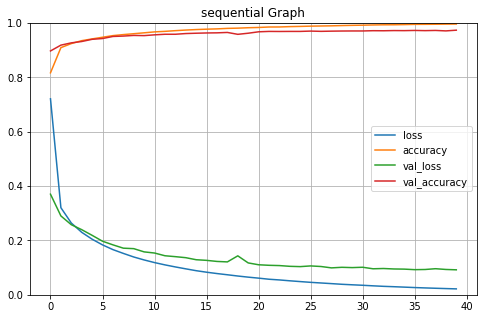

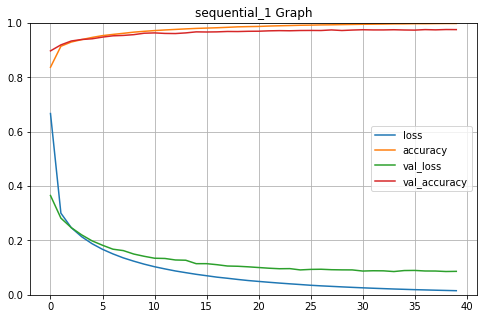

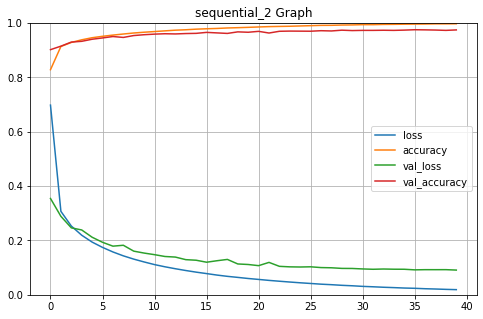

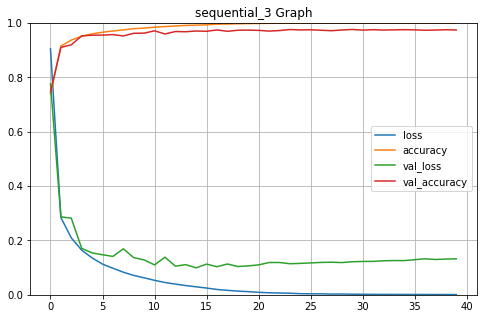

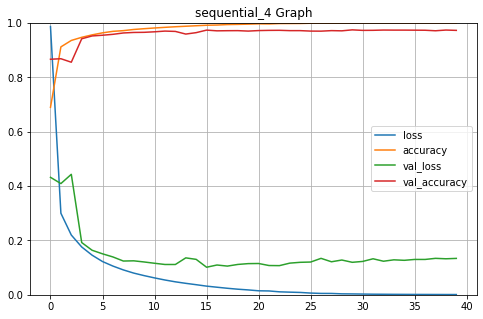

In [9]:
for m in models:
    pd.DataFrame(m.history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.title(f'{m._name} Graph')
plt.savefig('sequential_graphs.png')

In [10]:
losses = []
tst_losses = []
accuracys = []
tst_accuracys = []
for m in models:
    (loss,acc) = m.evaluate(X_train,y_train)
    (tst_loss,tst_acc) = m.evaluate(X_val, y_val)
    losses.append(loss)
    tst_losses.append(tst_loss)
    accuracys.append(acc)
    tst_accuracys.append(tst_acc)


132/132 [==============================] - 0s 681us/step - loss: 0.1339 - accuracy: 0.9729


In [11]:
d = {'model_name': ['1','2','3','4','5'], 
    'nodes_in_layers': [[300,100],[1000,100],[500,100],[300,100,300,100,100],[200,200,200,100,100]],
    'num_layers':[2,2,2,5,5],
    'process_time': times,
    'trng_accr': accuracys,
    'tst_accr': tst_accuracys}
results_df = pd.DataFrame(d)

In [16]:
tst_predictions = []
for m in models:
    test_prediction = m.predict(X_test)
    test_predictions_classes = np.argmax(m.predict(X_test), axis=-1)
    tst_predictions.append(test_predictions_classes)

In [18]:
for i in range(len(models)):
    results = pd.DataFrame(tst_predictions[i])
    results.index = np.arange(1, len(results) + 1)
    results.to_csv(f'{i}_model_results.csv')

# Summary
## Kaggle Team Name: Digit Finders
# Model Accuracy Results

In [12]:
results_df

,model_name,nodes_in_layers,num_layers,process_time,trng_accr,tst_accr
0,1,"[300, 100]",2,00:00:44.781677,0.997275,0.973571
1,2,"[1000, 100]",2,00:02:05.048330,0.998810,0.975714
2,3,"[500, 100]",2,00:01:19.871235,0.997593,0.974524
3,4,"[300, 100, 300, 100, 100]",5,00:01:00.651780,0.999974,0.974286
4,5,"[200, 200, 200, 100, 100]",5,00:01:06.290884,1.000000,0.972857


Our results were very favorable for relu in the 97th percentile.